In [1]:
import tensorflow as tf

In [2]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
params = {
    'lr': 0.001,
    'beta1': 0.5,
    'num_epochs': 500,    
    'image_dim': 28*28*3, 
    'noise_dim': 100, 
    'seed': 3333, 
    'batch_size': 128,
    'gen_size': 25, 
    'stddev': 0.02, 
    'alpha': 0.1
}

# Build dataset

In [4]:
input_dir = 'inputs/img_align_celeba'
input_names = [os.path.join(input_dir, f) for f in os.listdir(input_dir)]
num_inputs = len(input_names)

In [5]:
# Testing
#input_names[:5]

In [6]:
#Testing
img = plt.imread(input_names[1])
img.shape

(218, 178, 3)

In [7]:
from PIL import Image
def transform(image_name):
    image = Image.open(image_name)    
    image_width, image_height = image.size[0], image.size[1]
    face_width = face_height = 108
    #print(image.size)
    
    j = (image_width - face_width)//2
    i = (image_height - face_height)//2
    image = image.crop((j, i, j+face_width, i+face_height))
    image = image.resize([28, 28], Image.BILINEAR)
    #print(image.size)

    image = np.array(image.convert('RGB'))
    #print(image.shape)
    min_image = 0
    max_image = 255
    image_transformed = (image - min_image)/(max_image - min_image)
    #print(image_transformed.shape)
    
    image_transformed = image_transformed.astype(np.float32)
    #print(image_flatten.shape)

    return image_transformed

In [8]:
# #Testing
# transform(input_names[2])

In [9]:
# # Save the preprocessed images, otherwise
# images_transformed = []
# num = len(input_names)
# for idx, name in enumerate(input_names):
#     image_transformed = transform(name)
#     images_transformed.append(image_transformed)
#     if idx % 10000 == 0 :
#         print("%d/%d images done"%(idx, num))
# images_transformed = np.array(images_transformed)
# np.save('images_transformed.npy', images_transformed)

In [10]:
data = np.load("images_transformed.npy") 
data_placeholder = tf.placeholder(data.dtype, data.shape) 
dataset = tf.contrib.data.Dataset.from_tensor_slices(data_placeholder)
dataset = dataset.shuffle(buffer_size=10000)
dataset = dataset.batch(params['batch_size'])
dataset = dataset.repeat(params['num_epochs'])
print(dataset.output_shapes)

Instructions for updating:
Use `tf.data.Dataset.from_tensor_slices()`.
(?, 28, 28, 3)


In [11]:
# if transform was done by batch, gpu will not be fast enough. This is probably caused by the slow transform.

# train_names_tf = tf.constant(input_names)
# trainset = tf.contrib.data.Dataset.from_tensor_slices(train_names_tf)
# trainset = trainset.map(lambda filename: tf.py_func(transform, [filename], [tf.float32]))
# trainset = trainset.shuffle(buffer_size=10000)
# trainset = trainset.batch(params['batch_size'])
# trainset = trainset.repeat(params['num_epochs'])

# Build model

In [12]:
class DCGAN():
    def __init__(self, params=params, is_train=True):
        
        self.params = params
        self.is_train = is_train
        self.initializer = tf.random_normal_initializer(stddev=self.params['stddev'])
        self.is_train = is_train
            
    def generator(self, z, reuse=False):
        
        with tf.variable_scope('generator', reuse=reuse):

            # Layer 1 in: 7x7x256
            layer_1 = tf.layers.dense(z, 4 * 4 * 512)
            layer_1 = tf.reshape(layer_1, (-1, 4, 4, 512))
            layer_1 = tf.layers.batch_normalization(layer_1, training=self.is_train)
            layer_1 = tf.maximum(self.params['alpha'] * layer_1, layer_1)
            # Layer 1 out: 4x4x512

            layer_2 = tf.layers.conv2d_transpose(layer_1, 128, 4, 1, padding='valid', kernel_initializer=self.initializer)
            layer_2 = tf.layers.batch_normalization(layer_2, training=self.is_train)
            layer_2 = tf.maximum(self.params['alpha'] * layer_2, layer_2)
            # Layer 2 out: 8x8x128

            layer_3 = tf.layers.conv2d_transpose(layer_2, 64, 5, 2, padding='same', kernel_initializer=self.initializer)
            layer_3 = tf.layers.batch_normalization(layer_3, training=self.is_train)
            layer_3 = tf.maximum(self.params['alpha'] * layer_3, layer_3)
            # Layer 3 out: 16x16x64

            layer_4 = tf.layers.conv2d_transpose(layer_3, 32, 5, 2, padding='same',kernel_initializer=self.initializer)
            layer_4 = tf.layers.batch_normalization(layer_4, training=self.is_train)
            layer_4 = tf.maximum(self.params['alpha'] * layer_4, layer_4)
            # Layer 4 out: 32x32x32

            logits = tf.layers.conv2d_transpose(layer_4, 3, 3, 1, padding='same', kernel_initializer=self.initializer)
            output = tf.tanh(logits)
        
        return output
                
    def discriminator(self, images, reuse=False): 
        
        with tf.variable_scope('discriminator', reuse=reuse):
            # Layer 1 in: 28x28x(3)
            layer_1 = tf.layers.conv2d(images, 32, 5, 2, padding='same', kernel_initializer=self.initializer)
            layer_1 = tf.maximum(self.params['alpha'] * layer_1, layer_1)
            # Layer 1 out: 14x14x32

            # Layer 2: 14x14x32
            layer_2 = tf.layers.conv2d(layer_1, 64, 5, 2, padding='same', kernel_initializer=self.initializer)
            layer_2 = tf.layers.batch_normalization(layer_2, training=self.is_train)
            layer_2 = tf.maximum(self.params['alpha'] * layer_2, layer_2)
            # Layer 2 out: 7x7x64

            layer_3 = tf.layers.conv2d(layer_2, 128, 5, 2, padding='same',  kernel_initializer=self.initializer)
            layer_3 = tf.layers.batch_normalization(layer_3, training=self.is_train)
            layer_3 = tf.maximum(self.params['alpha'] * layer_3, layer_3)
            # Layer 3 out: 4x4x128

            layer_4 = tf.layers.conv2d(layer_3, 256, 5, 2, padding='same', kernel_initializer=self.initializer)
            layer_4 = tf.layers.batch_normalization(layer_4, training=self.is_train)
            layer_4 = tf.maximum(self.params['alpha'] * layer_4, layer_4)
            # Layer 4 out: 2x2x256

            flattened = tf.reshape(layer_4, (-1, 2*2*256))
            logits = tf.layers.dense(flattened, 1, kernel_initializer=self.initializer)
        
        return logits

    
    def forward(self, real_input, z):
        with tf.name_scope('logits'):
            fake_input = self.generator(z)
            dis_logits_real = self.discriminator(real_input)
            dis_logits_fake = self.discriminator(fake_input, reuse=True)
        
        return dis_logits_real, dis_logits_fake
    
    def create_loss(self, dis_logits_real, dis_logits_fake):
              
        with tf.name_scope('loss'):    
            dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
            dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
            dis_loss = dis_loss_real + dis_loss_fake
            gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
            
        return dis_loss, gen_loss 
    
    def create_gen_optimizer(self, gen_loss):
        
        gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="generator")        
        gen_updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
        
        with tf.control_dependencies(gen_updates):
            gen_train_op = tf.train.AdamOptimizer(self.params['lr'], beta1=self.params['beta1']).minimize(gen_loss, var_list=gen_vars)
        
        return gen_train_op
    
    def create_dis_optimizer(self, dis_loss):
        
        dis_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="discriminator")        
        dis_updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
        
        with tf.control_dependencies(dis_updates):
            dis_train_op = tf.train.AdamOptimizer(self.params['lr'], beta1=self.params['beta1']).minimize(dis_loss, var_list=dis_vars)
        
        return dis_train_op
    
    def create_summary(self, gen_loss, dis_loss):
        
        with tf.name_scope("summaries"):
            gen_summary_op = tf.summary.scalar("gen_loss", gen_loss)
            dis_summary_op = tf.summary.scalar("dis_loss", dis_loss)
            summary_op = tf.summary.merge_all()
        
        return summary_op
        
    def train(self):
        
        self.real_input = tf.placeholder(tf.float32, shape=(None, 28, 28, 3))
        self.z = tf.placeholder(tf.float32, shape=(None, self.params['noise_dim'])) 
        
        dis_logits_real, dis_logits_fake = self.forward(self.real_input, self.z)

        dis_loss, gen_loss = self.create_loss(dis_logits_real, dis_logits_fake)
        dis_train_op = self.create_dis_optimizer(dis_loss)
        gen_train_op = self.create_gen_optimizer(gen_loss)
        
        summary_op = self.create_summary(gen_loss, dis_loss)

        return dis_train_op, gen_train_op, dis_loss, gen_loss, summary_op
    
    def generate(self):
        
        self.gen_input = tf.placeholder(tf.float32, shape=(None, self.params['noise_dim']))
        self.is_train = False
        output = self.generator(self.gen_input, reuse=True)
        
        return output

# Train model

In [13]:
log_dir = "log_dcgan"

In [14]:
import math

def display_images(images, gen_size=params['gen_size']):
    fig = plt.figure()
    for idx, image in enumerate(images):
        image = (image - np.min(image))/(np.max(image) - np.min(image)) * 255
        image = image.reshape(28, 28, 3)
        ax = fig.add_subplot(5, 5, idx+1)
        #plt.subplots_adjust(wspace=0.01, hspace=0.01)
        ax.set_axis_off()
        ax.imshow(image)
    plt.show() # this line make sure the image is loaded to console before executing next line of code

In [15]:
with tf.device('/gpu:0'):
    tf.set_random_seed(params['seed'])
    model = DCGAN()
    dis_train_op, gen_train_op, dis_loss, gen_loss, summary_op = model.train()
    #saver = tf.train.Saver()
    init = tf.global_variables_initializer()
    iterator = dataset.make_initializable_iterator()
    next_batch = iterator.get_next()

Start training
Epoch 0, dis_loss: 1.03, gen_loss: 1.63, running_time: 71


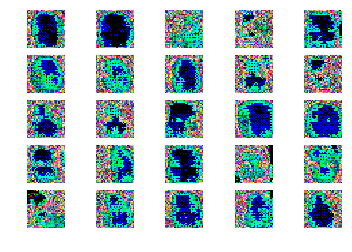

Epoch 1, dis_loss: 1.03, gen_loss: 1.55, running_time: 72
Epoch 2, dis_loss: 1.07, gen_loss: 1.41, running_time: 74
Epoch 3, dis_loss: 1.12, gen_loss: 1.31, running_time: 75
Epoch 4, dis_loss: 1.17, gen_loss: 1.22, running_time: 76
Epoch 5, dis_loss: 1.18, gen_loss: 1.18, running_time: 76
Epoch 6, dis_loss: 1.18, gen_loss: 1.19, running_time: 77
Epoch 7, dis_loss: 1.17, gen_loss: 1.20, running_time: 77
Epoch 8, dis_loss: 1.16, gen_loss: 1.23, running_time: 77
Epoch 9, dis_loss: 1.14, gen_loss: 1.25, running_time: 78
Epoch 10, dis_loss: 1.11, gen_loss: 1.31, running_time: 77


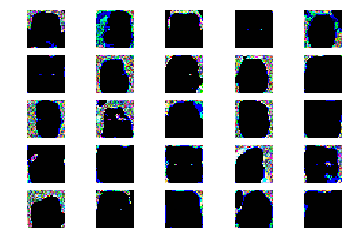

Epoch 11, dis_loss: 1.09, gen_loss: 1.36, running_time: 74
Epoch 12, dis_loss: 1.07, gen_loss: 1.41, running_time: 73
Epoch 13, dis_loss: 1.05, gen_loss: 1.46, running_time: 73
Epoch 14, dis_loss: 1.02, gen_loss: 1.53, running_time: 73
Epoch 15, dis_loss: 0.99, gen_loss: 1.59, running_time: 74
Epoch 16, dis_loss: 0.97, gen_loss: 1.66, running_time: 74
Epoch 17, dis_loss: 0.95, gen_loss: 1.71, running_time: 74
Epoch 18, dis_loss: 0.92, gen_loss: 1.79, running_time: 74
Epoch 19, dis_loss: 0.90, gen_loss: 1.86, running_time: 74
Epoch 20, dis_loss: 0.88, gen_loss: 1.91, running_time: 74


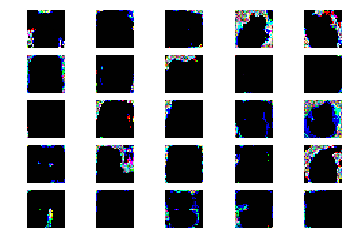

Epoch 21, dis_loss: 0.86, gen_loss: 1.97, running_time: 74
Epoch 22, dis_loss: 0.84, gen_loss: 2.02, running_time: 74
Epoch 23, dis_loss: 0.82, gen_loss: 2.08, running_time: 74
Epoch 24, dis_loss: 0.82, gen_loss: 2.12, running_time: 74
Epoch 25, dis_loss: 0.78, gen_loss: 2.19, running_time: 74
Epoch 26, dis_loss: 0.77, gen_loss: 2.27, running_time: 74
Epoch 27, dis_loss: 0.76, gen_loss: 2.31, running_time: 74
Epoch 28, dis_loss: 0.74, gen_loss: 2.35, running_time: 74
Epoch 29, dis_loss: 0.73, gen_loss: 2.41, running_time: 74
Epoch 30, dis_loss: 0.72, gen_loss: 2.43, running_time: 74


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


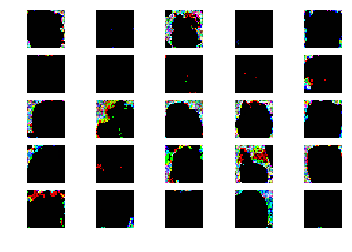

Epoch 31, dis_loss: 0.71, gen_loss: 2.50, running_time: 74
Epoch 32, dis_loss: 0.69, gen_loss: 2.53, running_time: 74
Epoch 33, dis_loss: 0.70, gen_loss: 2.56, running_time: 74
Epoch 34, dis_loss: 0.68, gen_loss: 2.60, running_time: 74
Epoch 35, dis_loss: 0.66, gen_loss: 2.67, running_time: 74
Epoch 36, dis_loss: 0.66, gen_loss: 2.70, running_time: 74
Epoch 37, dis_loss: 0.65, gen_loss: 2.75, running_time: 74
Epoch 38, dis_loss: 0.65, gen_loss: 2.76, running_time: 74
Epoch 39, dis_loss: 0.65, gen_loss: 2.78, running_time: 74
Epoch 40, dis_loss: 0.63, gen_loss: 2.83, running_time: 74


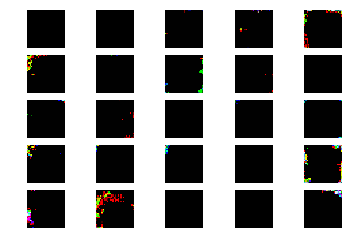

Epoch 41, dis_loss: 0.63, gen_loss: 2.83, running_time: 74
Epoch 42, dis_loss: 0.62, gen_loss: 2.89, running_time: 74
Epoch 43, dis_loss: 0.62, gen_loss: 2.89, running_time: 74
Epoch 44, dis_loss: 0.61, gen_loss: 2.95, running_time: 74
Epoch 45, dis_loss: 0.61, gen_loss: 2.95, running_time: 74
Epoch 46, dis_loss: 0.61, gen_loss: 2.94, running_time: 74
Epoch 47, dis_loss: 0.58, gen_loss: 3.05, running_time: 74
Epoch 48, dis_loss: 0.60, gen_loss: 3.03, running_time: 74
Epoch 49, dis_loss: 0.59, gen_loss: 3.04, running_time: 74


KeyboardInterrupt: 

In [16]:
import time

with tf.Session(config=tf.ConfigProto(log_device_placement=True, allow_soft_placement = True)) as sess:

    sess.run(init)    
    train_writer = tf.summary.FileWriter(log_dir)
    sess.run(iterator.initializer, feed_dict={data_placeholder: data})
    
    print("Start training")

    for epoch in range(params['num_epochs']):

        dis_loss_total = []
        gen_loss_total = []
        num_batches = int(num_inputs/params['batch_size']) + 1

        # train
        a = time.time()
        for batch_idx in range(num_batches):
            global_step = epoch * params['batch_size'] + batch_idx   
            
            batch = sess.run(next_batch)
            z = np.random.uniform(-1, 1, size=(params['batch_size'], params['noise_dim']))             
            feed_dict = {model.real_input: batch, model.z: z}
            
            _, _, dis_loss_value, gen_loss_value, summary = sess.run([dis_train_op, gen_train_op, dis_loss, gen_loss, summary_op], feed_dict=feed_dict)
            dis_loss_total.append(dis_loss_value)
            gen_loss_total.append(gen_loss_value)
            train_writer.add_summary(summary, global_step=global_step)
            
        b = time.time()

        #display epoch result
        dis_loss_epoch = np.array(dis_loss_total).mean()
        gen_loss_epoch = np.array(gen_loss_total).mean() 
        
        print("Epoch %d, dis_loss: %.2f, gen_loss: %.2f, running_time: %d" %(epoch, dis_loss_epoch, gen_loss_epoch, b-a))

        if epoch % 10 == 0:
            gen_op = model.generate()
            z = np.random.uniform(-1, 1, size=(params['gen_size'], params['noise_dim']))
            #print(z.shape)
            gen_feed_dict = {model.gen_input: z}
            output_images = sess.run(gen_op, feed_dict=gen_feed_dict)
            display_images(output_images)

In [ ]:
# TODO:
# https://github.com/soumith/ganhacks/issues/14
# label smoothing
# label switching
# add gaussian noise